# ML Live

Bjoern Rost & Stewart Bryson

In [1]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Let's write a SQL query to pick up interesting fields from the dataset.

In [3]:
%sql --module afewrecords
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] LIMIT 10

In [4]:
trips = bq.Query(afewrecords).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2010-03-21 16:54:43,-73.973613,40.792270,-73.973670,40.792168,1,0.0,0.0,0.0,0.0
1,2010-02-09 06:48:04,-73.776446,40.646022,-73.776446,40.646022,1,0.0,0.0,0.0,0.0
2,2015-02-08 14:23:56,-73.937599,40.758228,-73.937614,40.758259,1,0.0,0.0,0.0,0.0
3,2010-02-02 21:16:08,-73.987630,40.757960,-73.984313,40.768847,1,0.0,0.0,0.0,0.0
4,2010-03-19 21:18:36,-73.984630,40.758817,-74.025551,40.754651,2,34.5,0.0,0.0,0.0
5,2013-08-22 20:39:00,-74.045757,40.740010,-74.045778,40.740040,1,0.0,0.0,0.0,0.0
6,2015-02-02 19:22:39,-73.937431,40.758427,-73.937691,40.758064,1,0.0,0.0,0.0,0.0
7,2015-01-16 16:05:23,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0.0
8,2010-02-15 10:55:12,-73.871434,40.771859,-73.885401,40.773195,1,1.4,0.0,0.0,0.0
9,2015-03-21 13:32:18,-73.937622,40.758221,-73.937622,40.758221,1,0.0,0.0,0.0,0.0


Let's increase the number of records so that we can do some neat graphs. There is no guarantee about the order in which records are returned, and so no guarantee about which records get returned if we simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in 100,000 records -- because there are 1 billion records in the data, we should get back approximately 10,000 records if we do this.

In [5]:
%sql --module afewrecords2
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  ABS(HASH(pickup_datetime)) % $EVERY_N == 1

In [6]:
trips = bq.Query(afewrecords2, EVERY_N=100000).to_dataframe()
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2012-09-05 15:45:00,-74.005060,40.740822,-73.991710,40.740013,1,1.06,0.0,7.0,9.60
1,2014-07-20 02:20:38,-73.989582,40.720431,-74.004260,40.722064,4,1.40,0.0,8.0,9.00
2,2011-09-28 21:18:00,-73.999112,40.728132,-73.997970,40.729373,2,0.14,0.0,2.9,3.90
3,2012-08-07 15:57:00,-73.975525,40.749587,-73.982450,40.748455,1,1.11,0.0,7.3,9.26
4,2012-05-03 02:10:13,-73.978615,40.762481,-73.971330,40.761918,1,0.40,0.0,3.3,4.30
5,2011-08-22 15:55:00,-73.980255,40.734427,-73.976530,40.739457,1,0.40,0.0,3.3,3.80
6,2009-02-16 11:54:00,-74.001587,40.730930,-73.991095,40.736888,1,1.06,0.0,6.1,6.10
7,2014-01-21 09:00:40,-73.988503,40.754173,-73.978938,40.747820,1,0.70,0.0,5.0,5.50
8,2009-02-04 21:04:05,-73.984054,40.737485,-73.968393,40.760387,1,1.80,0.0,7.0,8.08
9,2011-11-01 22:59:03,-73.983036,40.771251,-73.971680,40.748890,1,2.30,0.0,8.5,11.00


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


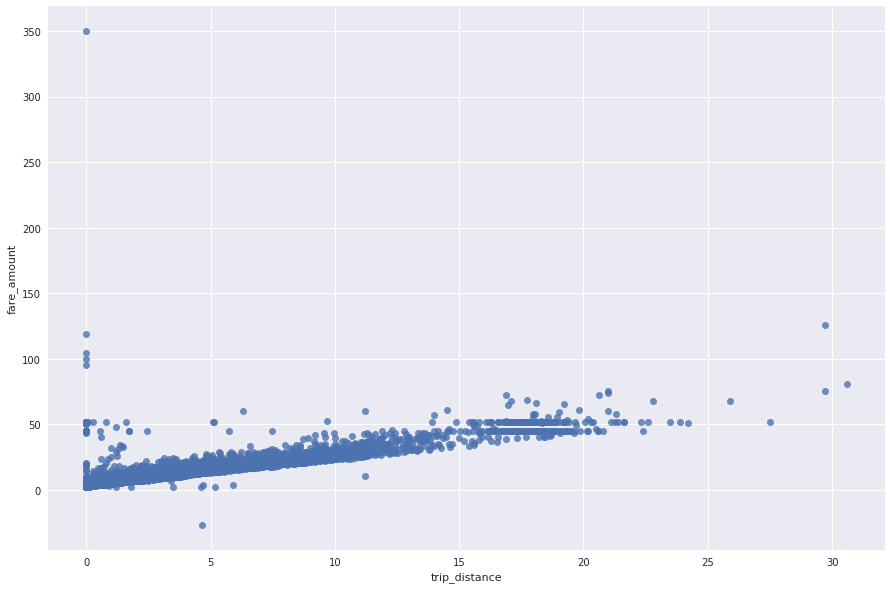

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [8]:
%sql --module afewrecords3
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  (ABS(HASH(pickup_datetime)) % $EVERY_N == 1 AND
  trip_distance > 0 AND fare_amount >= 2.5)

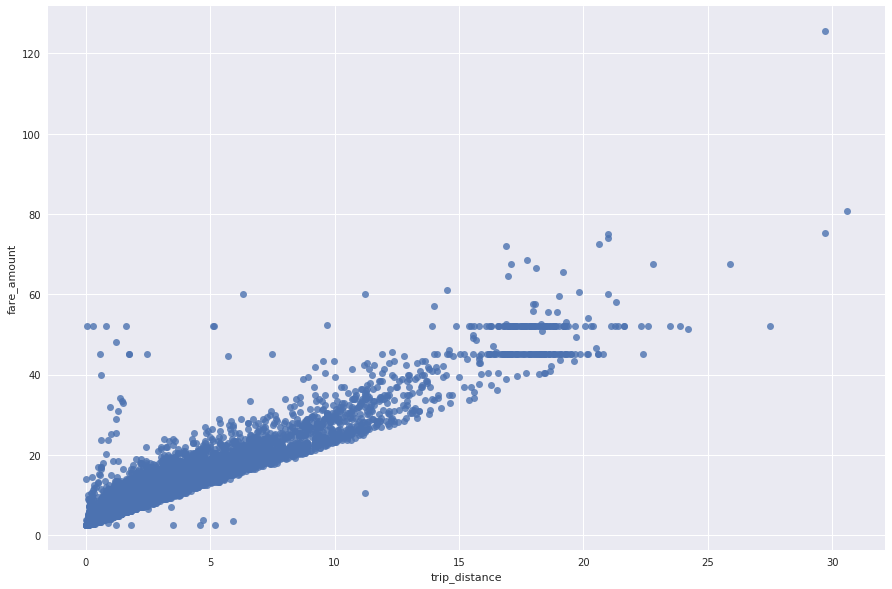

In [9]:
trips = bq.Query(afewrecords3, EVERY_N=100000).to_dataframe()
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

What's up with the streaks at <span>$</span>45 and \$50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's examine whether the toll amount is captured in the total amount.

In [10]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2012-09-05 15:45:00']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
78,2012-09-05 15:45:00,-73.776752,40.645120,-73.947410,40.776887,1,19.17,4.8,52.0,67.7
433,2012-09-05 15:45:00,-73.862842,40.769097,-73.864235,40.842857,1,11.47,4.8,32.5,37.8
846,2012-09-05 15:45:00,-73.873162,40.774097,-73.958280,40.760662,3,8.99,4.8,27.0,37.7
1458,2012-09-05 15:45:00,-73.993160,40.758052,-73.937263,40.588857,3,19.32,4.8,53.0,68.9
1736,2012-09-05 15:45:00,-73.961938,40.773337,-73.865820,40.769607,1,10.95,4.8,32.0,46.9
2386,2012-09-05 15:45:00,-73.872895,40.774047,-73.986535,40.745427,6,8.57,4.8,28.0,38.9
4539,2012-09-05 15:45:00,-73.781918,40.644722,-73.985535,40.763272,1,18.64,4.8,52.0,57.3
5812,2012-09-05 15:45:00,-73.974837,40.758055,-73.885452,40.773130,1,11.77,4.8,34.0,46.1
6832,2012-09-05 15:45:00,-73.977048,40.759600,-73.870900,40.774055,1,9.54,4.8,28.0,40.3
7431,2012-09-05 15:45:00,-73.976282,40.751292,-73.872445,40.774442,1,8.66,4.8,24.5,33.1


Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.

Let's also look at the distribution of values within the columns.

In [11]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.00000,11400.000000
mean,-72.527656,39.618013,-72.404513,39.868820,1.724298,2.838210,0.225352,11.00331,13.051914
std,18.541663,28.118268,11.567656,7.355304,1.345698,3.268861,1.103000,8.66286,10.482479
min,-1687.399757,-2895.273900,-74.417107,-444.385228,0.000000,0.010000,0.000000,2.50000,2.500000
25%,-73.992114,40.735475,-73.991601,40.733683,1.000000,1.010000,0.000000,6.00000,7.100000
50%,-73.981698,40.753039,-73.980396,40.753262,1.000000,1.740000,0.000000,8.40000,9.880000
75%,-73.966769,40.767687,-73.964285,40.768254,2.000000,3.160000,0.000000,12.50000,14.500000
max,0.009137,41.366138,443.321210,41.366138,6.000000,30.600000,19.500000,125.55000,149.630000


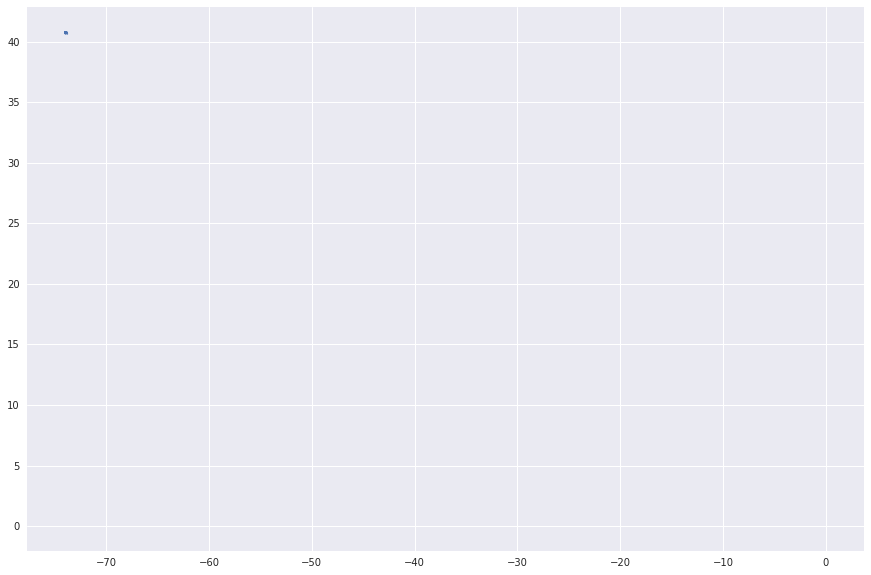

In [12]:
def showrides(df, numlines):
  import matplotlib.pyplot as plt
  lats = []
  lons = []
  for iter, row in df[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 10)
  plt.plot(lons, lats)

showrides(trips, 42)

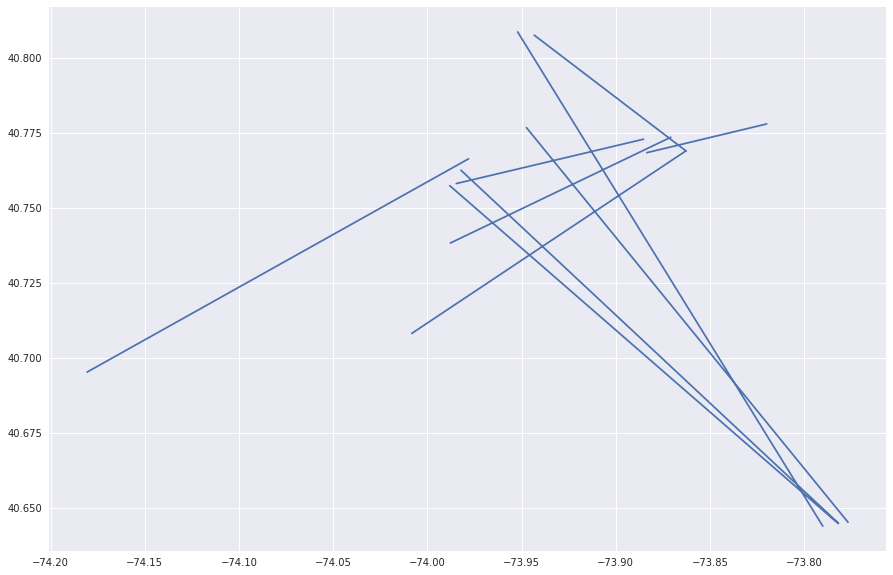

In [13]:
showrides(tollrides, 10)

<h3> Quality control and other preprocessing </h3>

We need to some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

We could do preprocessing in BigQuery, similar to how we removed the zero-distance rides, but just to show you another option, let's do this in Python.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.

In [14]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance']
  del trips['pickup_datetime']
  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,11101.000000,11101.000000,11101.000000,11101.000000,11101.000000,11101.000000
mean,-73.975294,40.751359,-73.974711,40.751343,1.730925,11.231066
std,0.038610,0.029801,0.038460,0.034012,1.343629,9.361325
min,-74.417107,40.277250,-74.417107,40.303627,1.000000,2.500000
25%,-73.992337,40.737100,-73.991878,40.735405,1.000000,6.000000
50%,-73.982062,40.753875,-73.980857,40.754000,1.000000,8.500000
75%,-73.968307,40.768101,-73.966165,40.768616,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,130.120000


The quality control has removed about 300 rows (11400 - 11101) or about 3% of the data. This seems reasonable.
Let's move on to creating the ML datasets.

<h3> Create ML datasets </h3>

Let's split the QCed data randomly into training, validation and test sets.

In [15]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [16]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000
mean,-73.975294,40.751512,-73.974506,40.751621,1.734749,11.282368
std,0.039229,0.030037,0.039324,0.034509,1.353300,9.425420
min,-74.417107,40.277250,-74.417107,40.303627,1.000000,2.500000
25%,-73.992437,40.737351,-73.991834,40.735302,1.000000,6.000000
50%,-73.982090,40.754017,-73.980891,40.754433,1.000000,8.100000
75%,-73.968088,40.768154,-73.965831,40.769014,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,130.120000


In [17]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,-73.974447,40.751111,-73.975314,40.750225,1.715916,11.117411
std,0.040972,0.031772,0.038351,0.035384,1.300570,9.241869
min,-74.041313,40.513587,-74.202110,40.514650,1.000000,2.500000
25%,-73.992026,40.736645,-73.992217,40.734931,1.000000,6.000000
50%,-73.982246,40.753982,-73.980930,40.752520,1.000000,8.500000
75%,-73.968260,40.768300,-73.966550,40.767307,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,86.700000


In [18]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000
mean,-73.976141,40.750894,-73.975069,40.751167,1.728091,11.105384
std,0.032840,0.026486,0.034279,0.030040,1.341378,9.181554
min,-74.041743,40.631723,-74.177997,40.619660,1.000000,2.500000
25%,-73.992059,40.736311,-73.991722,40.736961,1.000000,6.000000
50%,-73.981585,40.753431,-73.980483,40.753709,1.000000,8.300000
75%,-73.968954,40.767551,-73.966816,40.767930,2.000000,12.500000
max,-73.701325,40.845750,-73.704177,40.897331,6.000000,88.000000


Let's write out the three dataframes to appropriately named csv files. We can use these csv files for local training (recall that these files represent only 1/100,000 of the full dataset) until we get to point of using Dataflow and Cloud ML.

In [19]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

os.mkdir('data')
to_csv(df_train, 'data/taxi-train.csv')
to_csv(df_valid, 'data/taxi-valid.csv')
to_csv(df_test, 'data/taxi-test.csv')

OSError: [Errno 17] File exists: 'data'

In [33]:
!head -10 data/taxi-valid.csv

5.3,-73.982351,40.755546,-73.972826,40.751633,1,0
7.5,-73.984531,40.767441,-73.963029,40.774057,1,1
9.3,-73.989831,40.734114,-73.974882,40.72167,3,2
6.9,-73.981871,40.758431,-73.985612,40.73851,1,3
5.7,-74.004202,40.733462,-73.998283,40.724658,5,4
4.9,-74.009705,40.721818,-74.01042,40.709388,5,5
5.3,-73.973449,40.76044,-73.981963,40.768866,1,6
17.0,-73.993095,40.72794,-73.997935,40.756182,5,7
8.0,-73.956052,40.715477,-73.95901,40.716592,1,8
6.0,-73.985509,40.731557,-73.987172,40.720433,1,9


<h3> Verify that datasets exist </h3>

In [35]:
!ls -l data/*.csv

-rw-r--r-- 1 root root  90505 Oct  6 18:47 data/taxi-test.csv
-rw-r--r-- 1 root root 426610 Oct  6 18:47 data/taxi-train.csv
-rw-r--r-- 1 root root  90728 Oct  6 18:47 data/taxi-valid.csv


We have 3 .csv files corresponding to train, valid, test.  The ratio of file-sizes correspond to our split of the data.

Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

<h3> Benchmark </h3>

Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

My model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict.  Let's compute the RMSE of such a model.

In [36]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print ("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=columns)
df_test = pd.read_csv('taxi-test.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print ("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.5545980144020928/km
Train RMSE = 6.562771472582656
Valid RMSE = 7.148930019909793
Test RMSE = 5.728262161342763


### Benchmark on same dataset
The RMSE depends on the dataset, and for comparison, we have to evaluate on the same dataset each time. We'll use this query in later labs:

In [37]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key,
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(2, 100000)
df_valid = bq.Query(query).to_dataframe()
print_rmse(df_valid, 2.56, 'Final Validation Set')

Final Validation Set RMSE = 8.026346679177248


The simple distance-based rule gives us a RMSE of <b>$8.03</b>.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat.

Let's be ambitious, though, and make our goal to build ML models that have a RMSE of less than $6 on the test set.

<h1> Machine Learning using tf.estimator </h1>

In this notebook, we will create a machine learning model using tf.estimator and evaluate its performance.  The dataset is rather small (7700 samples), so we can do it all in-memory.  We will also simply pass the raw data in as-is. 

In [38]:
import datalab.bigquery as bq
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil

print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


Read data we created previously

In [40]:
# In CSV, label is the first column, after the features, followed by the key
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
FEATURES = CSV_COLUMNS[1:len(CSV_COLUMNS) - 1]
LABEL = CSV_COLUMNS[0]

df_train = pd.read_csv('./data/taxi-train.csv', header = None, names = CSV_COLUMNS)
df_valid = pd.read_csv('./data/taxi-valid.csv', header = None, names = CSV_COLUMNS)

<h2> Input function to read from Pandas Dataframe into tf.constant </h2>

In [41]:
def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

### Create feature columns for estimator

In [42]:
def make_feature_cols():
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]
  return input_columns

<h3> Linear Regression with tf.Estimator framework </h3>

In [45]:
tf.logging.set_verbosity(tf.logging.INFO)

OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)

model.train(input_fn = make_input_fn(df_train, num_epochs = 42))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd760398908>, '_num_worker_replicas': 1, '_task_type': 'worker', '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_is_chief': True, '_model_dir': 'taxi_trained', '_num_ps_replicas': 0, '_service': None, '_train_distribute': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 20473.988, st

Evaluate on the validation data (we should defer using the test data to after we have selected a final model).

In [46]:
def print_rmse(model, name, df):
  metrics = model.evaluate(input_fn = make_input_fn(df, 1))
  print('RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['average_loss'])))
print_rmse(model, 'validation', df_valid)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-06-22:42:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-2550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-06-22:42:15
INFO:tensorflow:Saving dict for global step 2550: average_loss = 98.340515, global_step = 2550, loss = 11695.497
RMSE on validation dataset = 9.916678428649902


This is nowhere near our benchmark (RMSE of $6 or so on this data), but it serves to demonstrate what TensorFlow code looks like.  Let's use this model for prediction.

In [48]:
import itertools
# Read saved model and use it for prediction
model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
preds_iter = model.predict(input_fn = make_input_fn(df_valid, 1))
print([pred['predictions'][0] for pred in list(itertools.islice(preds_iter, 10))])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd76d769198>, '_num_worker_replicas': 1, '_task_type': 'worker', '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_is_chief': True, '_model_dir': 'taxi_trained', '_num_ps_replicas': 0, '_service': None, '_train_distribute': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-2550
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[11.119684, 11.069832, 11.124538, 11.069142, 11.068923, 11.0696535, 11.070034, 1

This explains why the RMSE was so high -- the model essentially predicts the same amount for every trip.  Would a more complex model help? Let's try using a deep neural network.  The code to do this is quite straightforward as well.

<h3> Deep Neural Network regression </h3>

In [49]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
model = tf.estimator.DNNRegressor(hidden_units = [32, 8, 2],
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
model.train(input_fn = make_input_fn(df_train, num_epochs = 100));
print_rmse(model, 'validation', df_valid)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd7601cbf28>, '_num_worker_replicas': 1, '_task_type': 'worker', '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_is_chief': True, '_model_dir': 'taxi_trained', '_num_ps_replicas': 0, '_service': None, '_train_distribute': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 8101.559, ste

We are not beating our benchmark with either model ... what's up?  Well, we may be using TensorFlow for Machine Learning, but we are not yet using it well.  That's what the rest of this course is about!

But, for the record, let's say we had to choose between the two models. We'd choose the one with the lower validation error. Finally, we'd measure the RMSE on the test data with this chosen model.

In [51]:
import datalab.bigquery as bq
import numpy as np
import pandas as pd

def create_query(phase, EVERY_N):
  """
  phase: 1 = train 2 = valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key,
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      # Validation
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
    query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(2, 100000)
df = bq.Query(query).to_dataframe()

In [52]:
print_rmse(model, 'benchmark', df)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-06-23:01:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-6071
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-06-23:01:29
INFO:tensorflow:Saving dict for global step 6071: average_loss = 88.54328, global_step = 6071, loss = 11254.078
RMSE on benchmark dataset = 9.409744262695312


RMSE on benchmark dataset is 9.41 (your results will vary because of random seeds).

This is not only way more than our original benchmark of 6.00, but it doesn't even beat our distance-based rule's RMSE of 8.02.

Fear not -- you have learned how to write a TensorFlow model, but not to do all the things that you will have to do to your ML model performant. We will do this in the next chapters. In this chapter though, we will get our TensorFlow model ready for these improvements.

# Improving ML

## better data: Feature engineering

## more data: scale to cloud training

In [1]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade apache-beam[gcp]

Solving environment: ...working... done

# All requested packages already installed.

Requirement already up-to-date: apache-beam[gcp] in /usr/local/envs/py2env/lib/python2.7/site-packages (2.7.0)




==> WARNING: A newer version of conda exists. <==
  current version: 4.5.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base -c defaults conda


Skipping google-cloud-dataflow as it is not installed.


In [9]:
import tensorflow as tf
import apache_beam as beam
import shutil
print(tf.__version__)

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


# Setup GCP environment

<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. Therefore, we should <b>create a single-region bucket</b>. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available) </li>
</ol>
<b>Change the cell below</b> to reflect your Project ID and bucket name.

In [2]:
import os
PROJECT = 'rostlab-181304'    # CHANGE THIS
BUCKET = 'rostlab-181304-ml' # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
REGION = 'us-central1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.

In [3]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8' 

## ensure we're using python2 env
os.environ['CLOUDSDK_PYTHON'] = 'python2'

In [4]:
%%bash
## ensure gcloud is up to date
gcloud components update

gcloud config set project $PROJECT
gcloud config set compute/region $REGION

## ensure we predict locally with our current Python environment
gcloud config set ml_engine/local_python `which python`


All components are up to date.
Updated property [core/project].
Updated property [compute/region].
Updated property [ml_engine/local_python].


<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [5]:
def create_query(phase, EVERY_N):
  if EVERY_N == None:
    EVERY_N = 4 #use full dataset
    
  #select and pre-process fields
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
  
  #add subsampling criteria by modding with hashkey
  if phase == 'train': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} < 2".format(base_query,EVERY_N)
  elif phase == 'valid': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 2".format(base_query,EVERY_N)
  elif phase == 'test':
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 3".format(base_query,EVERY_N)
  return query
    
print(create_query('valid', 100)) #example query using 1% of data


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100 == 2


3. Preprocessing Dataflow job from BigQuery
This code reads from BigQuery and saves the data as-is on Google Cloud Storage. We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://www.tensorflow.org/api_docs/python/tf/contrib/cloud/BigQueryReader), it is quite convenient to export to CSV and do the training off CSV. Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [6]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

In [7]:
import datetime

####
# Arguments:
#   -rowdict: Dictionary. The beam bigquery reader returns a PCollection in
#     which each row is represented as a python dictionary
# Returns:
#   -rowstring: a comma separated string representation of the record with dayofweek
#     converted from int to string (e.g. 3 --> Tue)
####
def to_csv(rowdict):
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  rowdict['dayofweek'] = days[rowdict['dayofweek']]
  rowstring = ','.join([str(rowdict[k]) for k in CSV_COLUMNS])
  return rowstring


####
# Arguments:
#   -EVERY_N: Integer. Sample one out of every N rows from the full dataset.
#     Larger values will yield smaller sample
#   -RUNNER: 'DirectRunner' or 'DataflowRunner'. Specfy to run the pipeline
#     locally or on Google Cloud respectively. 
# Side-effects:
#   -Creates and executes dataflow pipeline. 
#     See https://beam.apache.org/documentation/programming-guide/#creating-a-pipeline
####
def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print('Launching Dataflow job {} ... hang on'.format(job_name))
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)

  #dictionary of pipeline options
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'runner': RUNNER
  }
  #instantiate PipelineOptions object using options dictionary
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  #instantantiate Pipeline object using PipelineOptions
  with beam.Pipeline(options=opts) as p:
      for phase in ['train', 'valid']:
        query = create_query(phase, EVERY_N) 
        outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(phase))
        (
          p | 'read_{}'.format(phase) >> beam.io.Read(beam.io.BigQuerySource(query=query))
            | 'tocsv_{}'.format(phase) >> beam.Map(to_csv)
            | 'write_{}'.format(phase) >> beam.io.Write(beam.io.WriteToText(outfile))
        )
  print("Done")

Run pipeline locally. This takes upto <b>5 minutes</b>.  You will see a message "Done" when it is done.

In [10]:
preprocess(50*10000, 'DirectRunner')

Launching Dataflow job preprocess-taxifeatures-181013-185943 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/runners/direct/direct_runner.py:357: DeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  pipeline.replace_all(_get_transform_overrides(pipeline.options))
/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)


Done


In [11]:
%%bash
gsutil ls gs://$BUCKET/taxifare/ch4/taxi_preproc/

gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00001-of-00005
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00002-of-00005
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00003-of-00005
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00004-of-00005
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00002
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00001-of-00002
gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/tmp/


## 4. Run Beam pipeline on Cloud Dataflow
Run pipleline on cloud on a larger sample size.

In [12]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

In [13]:
preprocess(50*100, 'DataflowRunner') 
#change first arg to None to preprocess full dataset

Launching Dataflow job preprocess-taxifeatures-181013-190935 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/runners/dataflow/dataflow_runner.py:777: DeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  standard_options = transform_node.inputs[0].pipeline.options.view_as(


Done


Once the job completes, observe the files created in Google Cloud Storage

In [14]:
%%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

  48668142  2018-10-13T19:16:18Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001
    108802  2018-10-13T19:00:11Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005
    113895  2018-10-13T19:00:11Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00001-of-00005
    114336  2018-10-13T19:00:11Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00002-of-00005
    114928  2018-10-13T19:00:11Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00003-of-00005
    114720  2018-10-13T19:00:11Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/train.csv-00004-of-00005
  24407527  2018-10-13T19:15:30Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001
    113574  2018-10-13T19:00:09Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00002
    106767  2018-10-13T19:00:09Z  gs://rostlab-181304-ml/taxifare/ch4/taxi_preproc/valid.csv-00001-of-00002
                            

In [15]:
%%bash
#print first 10 lines of first shard of train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

2.5,Sat,0,-73.986845,40.721068,-73.98649,40.721803,1.0,2009-01-17 00:04:32.000000-73.986840.721140.7218-73.9865
2.5,Sat,0,-74.002693,40.730647,-73.794683,40.667864,1.0,2009-09-12 00:43:28.000000-74.002740.730640.6679-73.7947
2.5,Mon,0,-73.998674,40.745071,-73.961467,40.757252,1.0,2013-07-01 00:23:13.000000-73.998740.745140.7573-73.9615
2.5,Wed,0,-74.040654,40.723487,-74.040467,40.724561,1.0,2012-03-14 00:01:25.000000-74.040740.723540.7246-74.0405
2.5,Thu,0,-73.91443,40.764659,-73.932049,40.76497,1.0,2012-01-12 00:17:34.000000-73.914440.764740.765-73.932
2.5,Thu,0,-74.005759,40.708276,-73.987198,40.721558,1.0,2012-12-20 00:19:59.000000-74.005840.708340.7216-73.9872
2.5,Mon,0,-73.992259,40.724403,-73.995071,40.725188,1.0,2010-11-01 00:54:58.000000-73.992340.724440.7252-73.9951
2.5,Sun,0,-73.987776,40.720903,-73.988202,40.720145,1.0,2013-01-13 00:19:08.000000-73.987840.720940.7201-73.9882
2.5,Sun,0,-73.932293,40.758035,-73.932788,40.758377,5.0,2010-03-28 00:52:00.000000-73.932340.75840.75

## 5. Develop model with new inputs

Download the first shard of the preprocessed data to enable local development.

In [17]:
%%bash
if [ -d sample ]; then
  rm -rf sample
fi
mkdir sample
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" > sample/train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" > sample/valid.csv

We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [18]:
%%bash
grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


In [19]:
%%bash
grep -A 50 "build_estimator" taxifare/trainer/model.py

def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, latdiff, londiff, euclidean, plon, plat, dlon, dlat, pcount) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.cr

In [20]:
%%bash
grep -A 15 "add_engineered(" taxifare/trainer/model.py

def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

--
    return tf.estimator.export.ServingInputReceiver(add_engineered(features), feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return 

In [21]:
%%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
python -m trainer.task \
  --train_data_paths=${PWD}/sample/train.csv \
  --eval_data_paths=${PWD}/sample/valid.csv  \
  --output_dir=${PWD}/taxi_trained \
  --train_steps=10 \
  --job-dir=/tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa2eb2202d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/ml-live/taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INF

In [22]:
%%bash
ls taxi_trained/export/exporter/

1539459688


You can use ```saved_model_cli``` to look at the exported signature. Note that the model doesn't need any of the engineered features as inputs. It will compute latdiff, londiff, euclidean from the provided inputs, thanks to the ```add_engineered``` call in the serving_input_fn.

In [24]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${PWD}/taxi_trained/export/exporter/${model_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dayofweek'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: Placeholder_8:0
    inputs['dropofflat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_2:0
    inputs['dropofflon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_3:0
    inputs['euclidean'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_7:0
    inputs['hourofday'] tensor_info:
        dtype: DT_INT32
        shape: (-1)
        name: Placeholder_9:0
    inputs['latdiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_5:0
    inputs['londiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_6:0
    inputs['passengers'] tensor_info:
        dtype: D

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
%%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

Overwriting /tmp/test.json


In [26]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

PREDICTIONS
[12.39254379272461]


  from ._conv import register_converters as _register_converters
2018-10-13 19:45:47.420835: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA



## 5. Train on cloud

This will take <b> 10-15 minutes </b> even though the prompt immediately returns after the job is submitted. Monitor job progress on the [Cloud Console, in the ML Engine](https://console.cloud.google.com/mlengine) section and wait for the training job to complete.

In [27]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=BASIC \
  --runtime-version=$TFVERSION \
  -- \
  --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
  --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

gs://rostlab-181304-ml/taxifare/ch4/taxi_trained us-central1 lab4a_181013_194632
jobId: lab4a_181013_194632
state: QUEUED


Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/#1539454919640121...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/checkpoint#1539454921239418...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/eval/#1539454536558787...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/eval/events.out.tfevents.1539454536.cmle-training-10145428242660528249#1539454931791864...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/events.out.tfevents.1539454517.cmle-training-10145428242660528249#1539454923063165...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/export/#1539454540155847...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/export/exporter/#1539454540352313...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/export/exporter/1539454539/#1539454544418771...
Removing gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/export/exporter/1539454539/saved_model.pb#1539454544585757...
Removing gs://rostlab-181304-ml/taxifare/ch4/tax

The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

In [31]:
%bash
gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1

gs://rostlab-181304-ml/taxifare/ch4/taxi_trained/export/exporter/1539460543/


In [32]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${model_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dayofweek'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: Placeholder_8:0
    inputs['dropofflat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_2:0
    inputs['dropofflon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_3:0
    inputs['euclidean'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_7:0
    inputs['hourofday'] tensor_info:
        dtype: DT_INT32
        shape: (-1)
        name: Placeholder_9:0
    inputs['latdiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_5:0
    inputs['londiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_6:0
    inputs['passengers'] tensor_info:
        dtype: D

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
gcloud ml-engine local predict \
  --model-dir=${model_dir} \
  --json-instances=/tmp/test.json

PREDICTIONS
[3.7441678047180176]


  from ._conv import register_converters as _register_converters
2018-10-13 20:23:21.926167: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA



6. Hyper-parameter tune
Look at hyper-parameter tuning notebook to decide what parameters to use for model. Based on that run, I ended up choosing:

train_batch_size: 512
nbuckets: 16
hidden_units: "64 64 64 8"
This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over a larger dataset.

In [35]:
%%bash

#WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://${BUCKET}/taxifare/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

gs://rostlab-181304-ml/taxifare/feateng2m us-central1 lab4a_181013_202631
jobId: lab4a_181013_202631
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [lab4a_181013_202631] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_181013_202631

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_181013_202631


### Start Tensorboard

In [36]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print(OUTDIR)
TensorBoard().start(OUTDIR)

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan


gs://rostlab-181304-ml/taxifare/feateng2m


TensorBoard was started successfully with pid 12312. Click here to access it.

12312

### Stop Tensorboard

In [ ]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:338: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


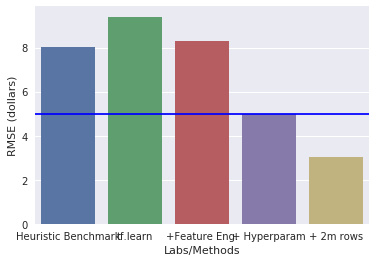

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License